<h2><center><font color="black"><strong>Model for flats in Lyon</strong></font></center></h2>

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [62]:
    # Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

    # Pipeline & Preprocess
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

    # Scores
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error , r2_score
from sklearn.metrics import mean_absolute_percentage_error

#### Import de la base

In [84]:
#df_Paris = pd.read_csv('../Data/update_data/df_Paris_Processed_Louise.csv', low_memory = False, encoding = 'latin1')
df = pd.read_csv('../Data/df_Lyon_appartement_vf.csv', low_memory = False, encoding = 'latin1')

In [65]:
#max_prix = np.quantile(df.Prix_m2, 0.9999)
#min_prix = np.quantile(df.Prix_m2, 0.001)

#df = df[(df.Prix_m2 < max_prix)
#                        & (df.Prix_m2 > min_prix)
#                        & (df.code_type_local == 2)]

**Run helpers**

In [85]:
%run '../Helpers/Data_Process.py'

In [86]:
%run '../Helpers/Models.py'

In [87]:
%run '../Helpers/Data_visualisation.py'

#### Visualisation de la base

In [88]:
df.head(4)

,id_mutation,date_mutation,code_type_local,code_commune,surface_terrain,surface_reelle_bati,nombre_pieces_principales,nature_culture,valeur_fonciere,latitude,longitude,nombre_lots,numero_disposition,code_departement,Nombre_unite,Nombre_dependance,Year,num_trimestre,quarter,geometry,index_right,epci_name,iris_code,iris_name,iris_name_l,Prix_m2,Month,Pris_m2_moy_iris,std,Vente_par_iris,Vente_par_iris_tri,N_logements,N_res_ppale,N_res_second,N_vacant,N_maisons,N_apparts,N_proprietaire,N_locataire,DISP_MED19,Ec_maternelle,Ec_elementaire,P19_LOG,P19_RP_SDB,P19_RP_CCCOLL,P19_RP_CCIND,P19_RP_CINDELEC,UU2020,COM,TRIRIS,GRD_QUART,TYP_IRIS,P19_POP1564,P19_POP1524,P19_POP2554,P19_POP5564,P19_ACT1564,P19_CHOM1564,P19_INACT1564,Part_dactifs,Part_chomeurs,Arrondissement,dist_metro
0,2017-484898,2017-07-04,2.0,69389,0.0,70.0,3.0,0,243350.0,45.773335,4.793648,1,1,69,1,1,2017,3,2017_Q3,POINT (4.793648 45.773335),14464,['MÃÂ©tropole de Lyon'],693890403,Le BÃÂ©al-Gorge de Lou,le bÃÂ©al-gorge de loup,3476.428571,7,3465.390792,725.3921,231,15,2093.0,1838.0,51.0,204.0,112.0,1963.0,579.0,1244.0,19790,1,1,2094.499045,1638.539607,583.962651,645.97907,595.27547,760,69389,691161,6938904,H,2428.018923,537.129556,1488.327205,402.562163,1739.71937,290.450895,688.299553,0.716518,0.119625,69389,904.291813
1,2017-484924,2017-07-07,2.0,69389,186.0,60.0,3.0,solssolssolssolssolssolssolssolssols,220000.0,45.769564,4.797702,0,1,69,1,8,2017,3,2017_Q3,POINT (4.797702 45.769564),14464,['MÃÂ©tropole de Lyon'],693890403,Le BÃÂ©al-Gorge de Lou,le bÃÂ©al-gorge de loup,3666.666667,7,3465.390792,725.3921,231,15,2093.0,1838.0,51.0,204.0,112.0,1963.0,579.0,1244.0,19790,1,1,2094.499045,1638.539607,583.962651,645.97907,595.27547,760,69389,691161,6938904,H,2428.018923,537.129556,1488.327205,402.562163,1739.71937,290.450895,688.299553,0.716518,0.119625,69389,656.341618
2,2017-484926,2017-07-03,2.0,69389,0.0,73.0,3.0,0,236750.0,45.772806,4.800751,2,1,69,1,0,2017,3,2017_Q3,POINT (4.800751 45.772806),14464,['MÃÂ©tropole de Lyon'],693890403,Le BÃÂ©al-Gorge de Lou,le bÃÂ©al-gorge de loup,3243.150685,7,3465.390792,725.3921,231,15,2093.0,1838.0,51.0,204.0,112.0,1963.0,579.0,1244.0,19790,1,1,2094.499045,1638.539607,583.962651,645.97907,595.27547,760,69389,691161,6938904,H,2428.018923,537.129556,1488.327205,402.562163,1739.71937,290.450895,688.299553,0.716518,0.119625,69389,370.704209
3,2017-485000,2017-07-04,2.0,69389,0.0,56.0,2.0,0,163000.0,45.772806,4.800751,2,1,69,1,1,2017,3,2017_Q3,POINT (4.800751 45.772806),14464,['MÃÂ©tropole de Lyon'],693890403,Le BÃÂ©al-Gorge de Lou,le bÃÂ©al-gorge de loup,2910.714286,7,3465.390792,725.3921,231,15,2093.0,1838.0,51.0,204.0,112.0,1963.0,579.0,1244.0,19790,1,1,2094.499045,1638.539607,583.962651,645.97907,595.27547,760,69389,691161,6938904,H,2428.018923,537.129556,1488.327205,402.562163,1739.71937,290.450895,688.299553,0.716518,0.119625,69389,370.704209


In [89]:
dummies_pr_var_continues(df, 'dist_metro', 0.01)
dummies_pr_var_continues(df, 'Nombre_dependance', 0)
#dummies_pr_var_continues(df, 'Ec_maternelle', 0)
#dummies_pr_var_continues(df, 'Ec_elementaire', 0)
dummies_pr_var_continues(df, 'nombre_pieces_principales', 3)

## Split temporel : 

In [154]:
df_train = df[df['date_mutation'] < '2021-04-01']
df_test = df[df['date_mutation'] >= '2021-04-01']

In [155]:
df_test.shape[0] / (df_train.shape[0] + df_test.shape[0])

0.2433232080160953

In [156]:
df_train = pd.concat([df_train, pd.get_dummies(df_train[['quarter']])], axis = 1)

In [157]:
df_train['group_bien_standard'] = 'group1'
df_train.loc[df_train['Arrondissement'].isin([69383, 69387, 69388]), 'group_bien_standard'] = 'group2'

In [158]:
df_train.group_bien_standard.value_counts()

group2    10063
group1     9118
Name: group_bien_standard, dtype: int64

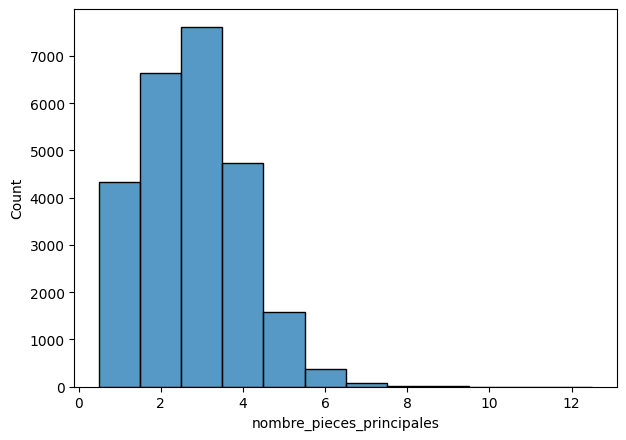

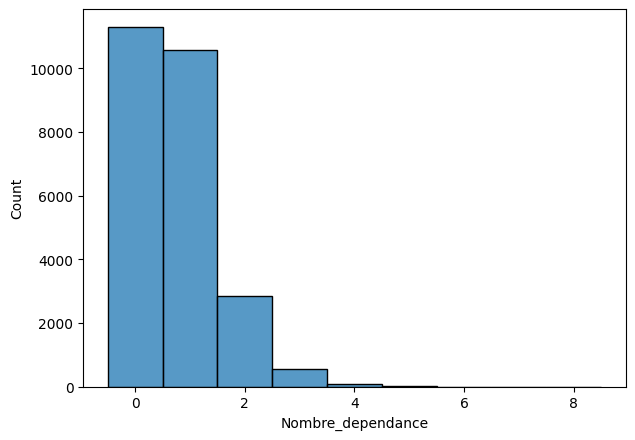

In [159]:
import seaborn as sc
sc.histplot(df['nombre_pieces_principales'], discrete = True)
plt.show()
sc.histplot(df['Nombre_dependance'], discrete = True)
plt.show()

69381


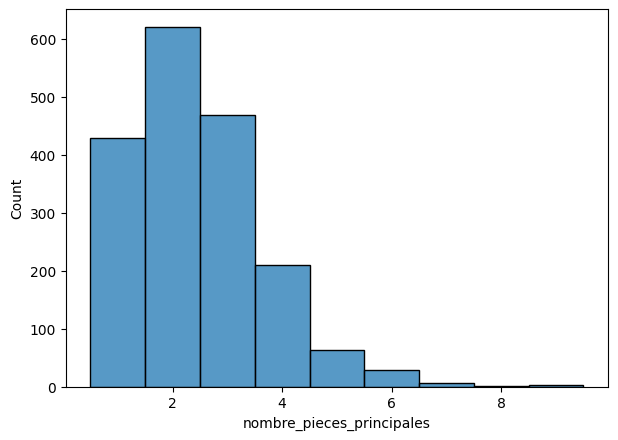

69382


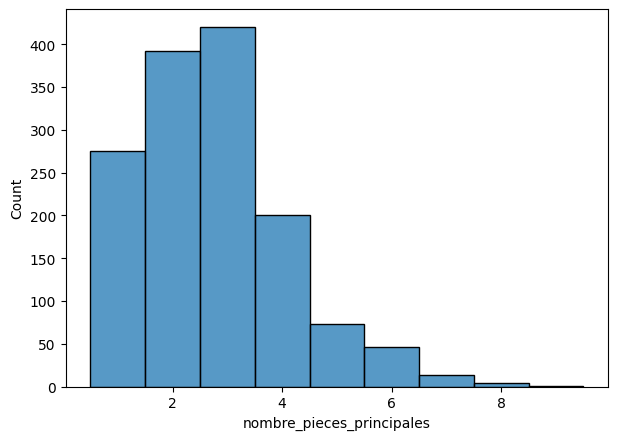

69383


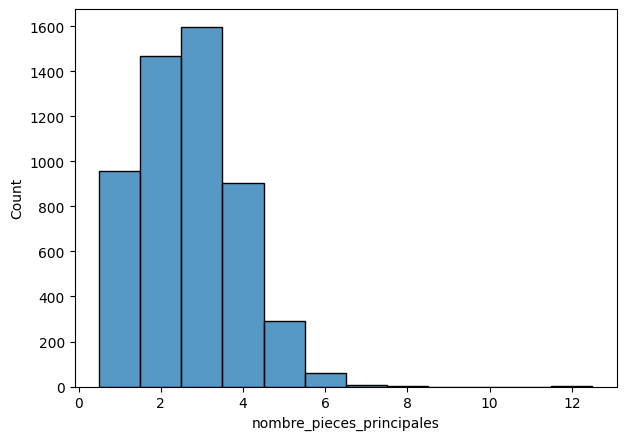

69384


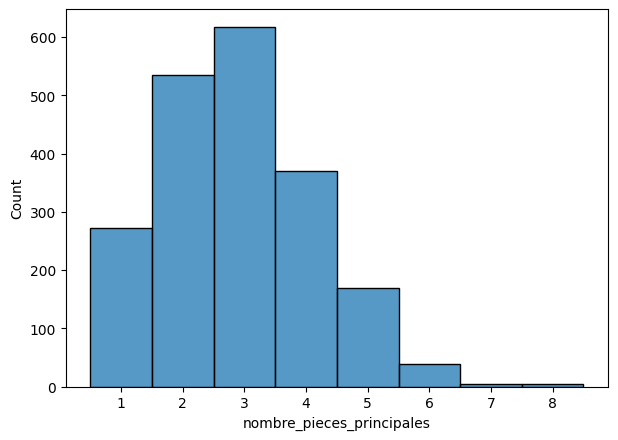

69385


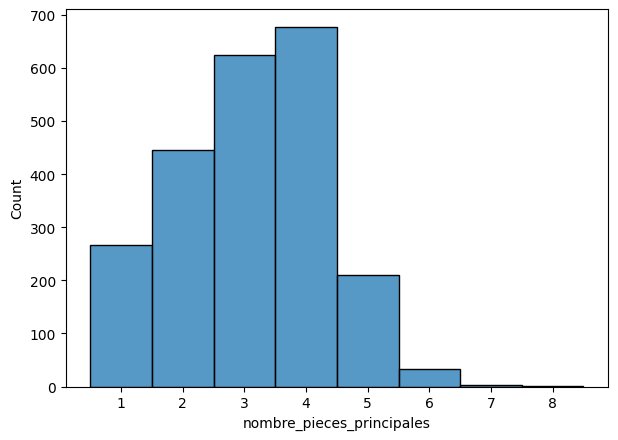

69386


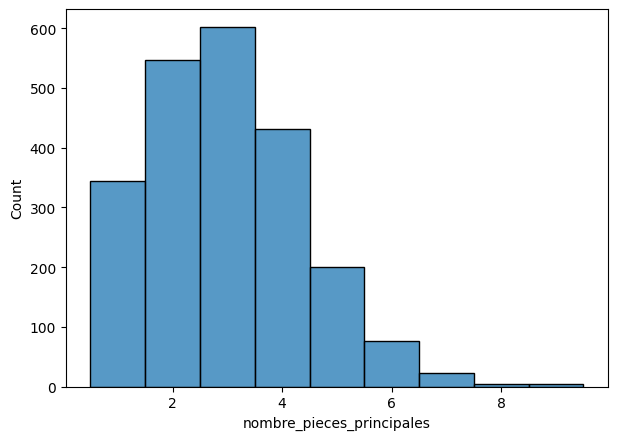

69387


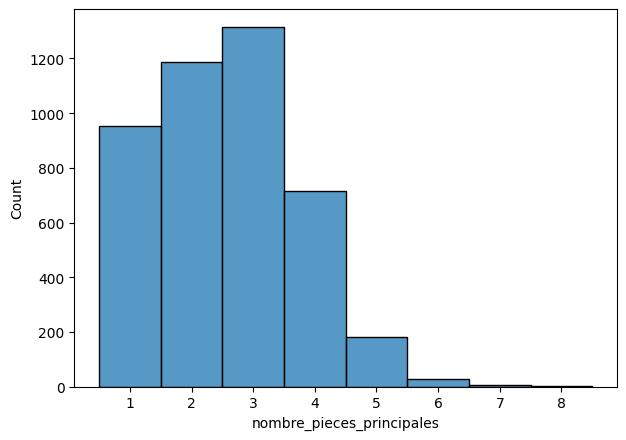

69388


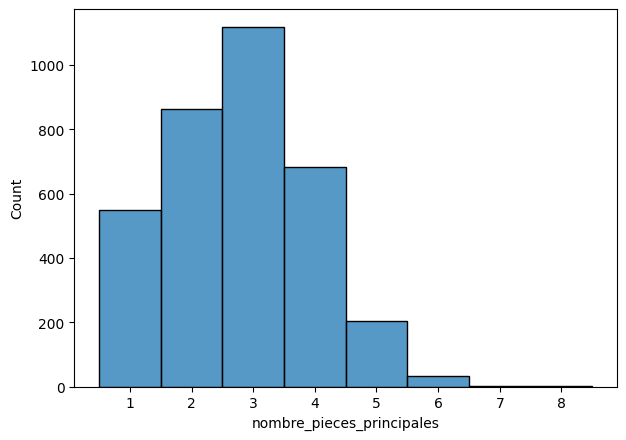

In [160]:
for i in range(1,9) : 
    code = 69380+i
    print(code)
    df_arr = df[df['code_commune'] == code]
    sc.histplot(df_arr['nombre_pieces_principales'], binwidth=1, discrete = True)
    plt.show()

69381


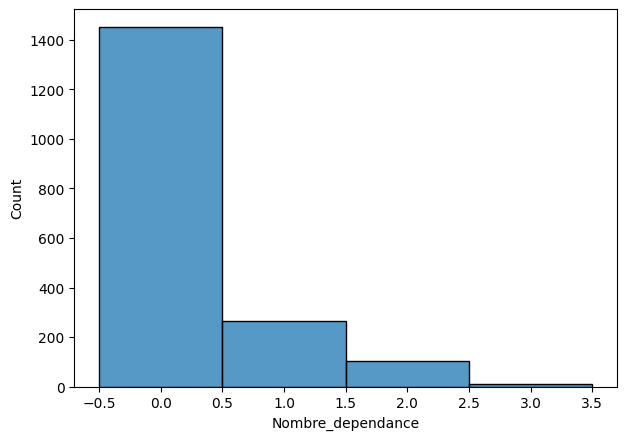

69382


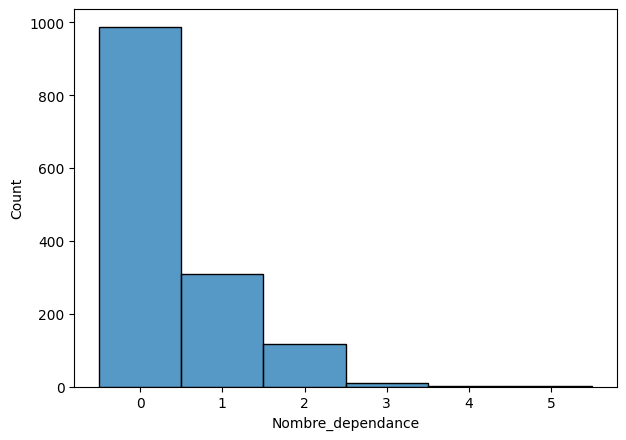

69383


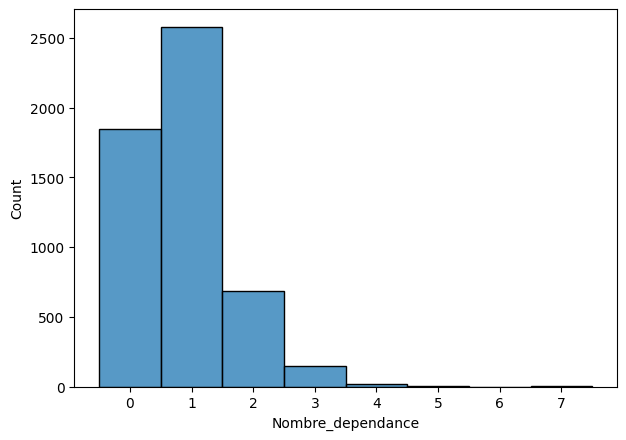

69384


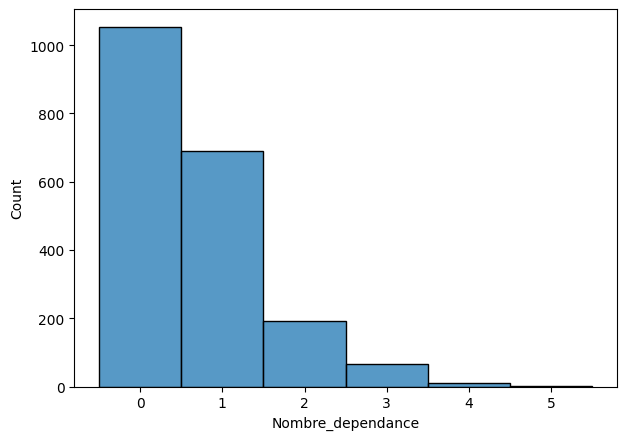

69385


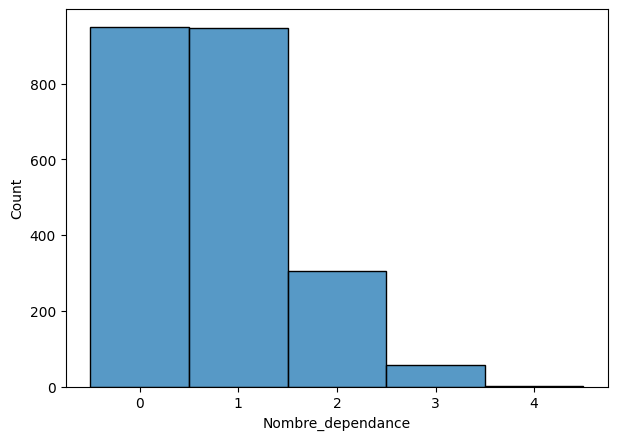

69386


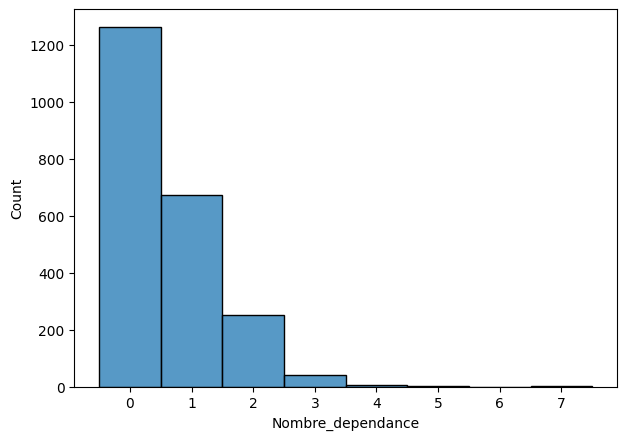

69387


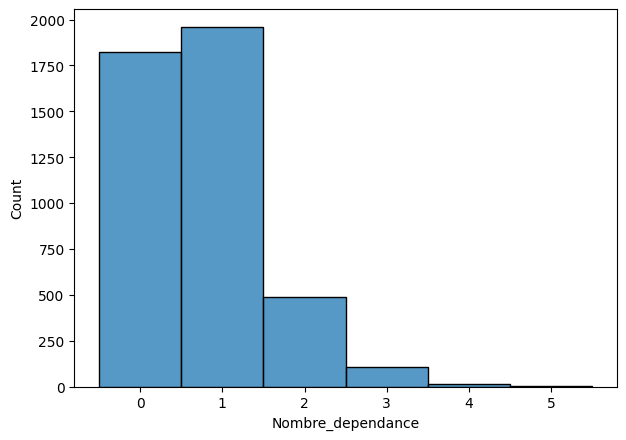

69388


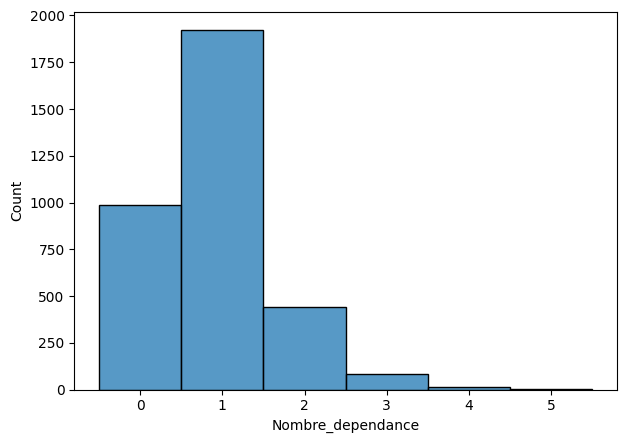

In [161]:
for i in range(1,9) : 
    code = 69380+i
    print(code)
    df_arr = df[df['code_commune'] == code]
    sc.histplot(df_arr['Nombre_dependance'], binwidth=1, discrete = True)
    plt.show()

## Indice de prix : 

In [162]:
df_train_1 = df_train[df_train['group_bien_standard'] == 'group1']
df_train_2 = df_train[df_train['group_bien_standard'] == 'group2']

In [163]:
df_train_1.shape[0], df_train_2.shape[0]

(9118, 10063)

In [164]:
def group(data, group, summary = False) :
    data['n_pieces_BienStandard'] = data['nombre_pieces_principales']-3
    if group == 'group1' :
        data['n_dependances_BienStandard'] = data['Nombre_dependance']
    if group == 'group2' : 
        data['n_dependances_BienStandard'] = data['Nombre_dependance'] - 1
    features_ols = ['quarter_2017_Q4', 'quarter_2018_Q1', 'quarter_2018_Q2', 'quarter_2018_Q3',
    'quarter_2018_Q4', 'quarter_2019_Q1', 'quarter_2019_Q2',
    'quarter_2019_Q3', 'quarter_2019_Q4', 'quarter_2020_Q1',
    'quarter_2020_Q2', 'quarter_2020_Q3', 'quarter_2020_Q4',
    'quarter_2021_Q1',
    'n_pieces_BienStandard', 'n_dependances_BienStandard']
    outcome = 'Prix_m2'
    model_group = model_OLS_prix(data, 'Prix_m2', features_ols, summary)
    return(model_group)

In [165]:
# Pour le group1 : nombre_pieces_principales = 3
# Nombre_dependance = 0

In [166]:
model1 = group(df_train_1, 'group1', summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     97.06
Date:                Sat, 01 Apr 2023   Prob (F-statistic):          5.16e-296
Time:                        16:30:29   Log-Likelihood:                -77713.
No. Observations:                9118   AIC:                         1.555e+05
Df Residuals:                    9101   BIC:                         1.556e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [167]:
# Pour le group2 : nombre_pieces_principales = 3
# Nombre_dependance = 1

In [168]:
model2 = group(df_train_2, 'group2', summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     198.5
Date:                Sat, 01 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:30:29   Log-Likelihood:                -81463.
No. Observations:               10063   AIC:                         1.630e+05
Df Residuals:                   10046   BIC:                         1.631e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

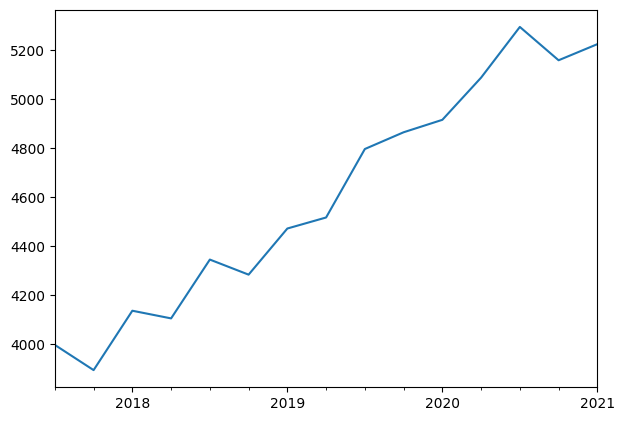

In [169]:
df_train_1 = add_indice_prix(df_train_1, indice_prix_quarter(model1, plot = True))

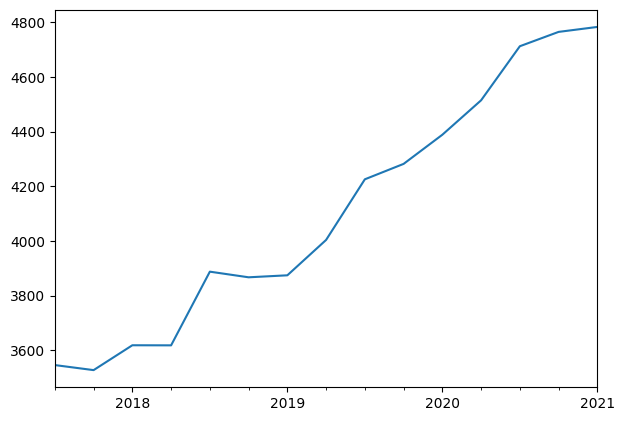

In [170]:
df_train_2 = add_indice_prix(df_train_2, indice_prix_quarter(model2, plot = True))

In [171]:
df_train = pd.concat([df_train_1, df_train_2], axis = 0)

In [172]:
df_train_1.shape[0] + df_train_2.shape[0]

19181

## Visualisation

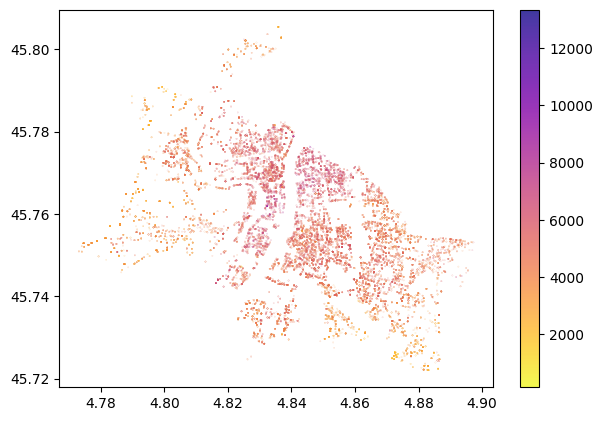

In [173]:
visualise(df, 'Prix_m2')

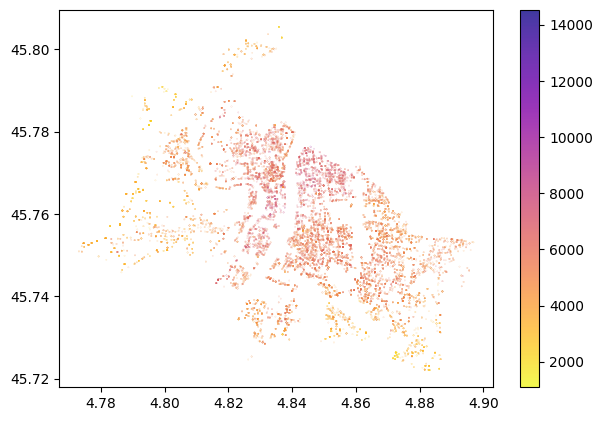

In [174]:
visualise(df_train, 'Prix_m2_actualise_Q1_2021')

## Sélection des features : 

In [176]:
df_test_vif = df[['nombre_pieces_principales','Nombre_dependance',
                  'N_apparts', 'Part_chomeurs', 'Ec_maternelle', 'Ec_elementaire',
                  'dist_metro']]

In [177]:
calc_vif(df_test_vif)

,variables,VIF
0,nombre_pieces_principales,5.463163
1,Nombre_dependance,2.076658
2,N_apparts,6.264683
3,Part_chomeurs,9.026997
4,Ec_maternelle,2.090434
5,Ec_elementaire,3.103578
6,dist_metro,2.360489


## <center> K plus proches voisins sur la latitude/longitude

Les features sont : 
- pour le KNN : 
    - latitude; longitude
- pour le Random Forest ou GBoost:
    - à compléter

In [178]:
    # Dependant variables : cooridnates
features_knn = ['latitude', 'longitude']
    # Output
label_train = 'Prix_m2_actualise_Q1_2021'
label_test = 'Prix_m2'

In [179]:
knn_pipe = model_KNN_coordinates(df_train, df_test, features_knn,
                          label_train, label_test,
                          MinMaxScaler(), 'uniform', 25, 5)

Returned hyperparameter: {'Knn__n_neighbors': 23}


In [180]:
    # Scores on TRAIN dataset
compute_scores(knn_pipe, df_train[features_knn], df_train[label_train])

MAPE:  11.298461296155482
MDAPE:  8.705737037715773


In [181]:
    # Scores on TEST dataset
compute_scores(knn_pipe, df_test[features_knn], df_test[label_test])

MAPE:  12.852732498435701
MDAPE:  9.033902078197652


## Etude du score

In [265]:
X_test = df_test.copy()
y_pred = knn_pipe.predict(X_test[features_knn])
X_test["y_pred"] = y_pred
X_test['y_true'] = df_test[label_test]
X_test['mdape'] = np.abs((X_test['y_true'] - X_test["y_pred"])/X_test['y_true'])*100
X_test.head(3)

,id_mutation,date_mutation,code_type_local,code_commune,surface_terrain,surface_reelle_bati,nombre_pieces_principales,nature_culture,valeur_fonciere,latitude,longitude,nombre_lots,numero_disposition,code_departement,Nombre_unite,Nombre_dependance,Year,num_trimestre,quarter,geometry,index_right,epci_name,iris_code,iris_name,iris_name_l,Prix_m2,Month,Pris_m2_moy_iris,std,Vente_par_iris,Vente_par_iris_tri,N_logements,N_res_ppale,N_res_second,N_vacant,N_maisons,N_apparts,N_proprietaire,N_locataire,DISP_MED19,Ec_maternelle,Ec_elementaire,P19_LOG,P19_RP_SDB,P19_RP_CCCOLL,P19_RP_CCIND,P19_RP_CINDELEC,UU2020,COM,TRIRIS,GRD_QUART,TYP_IRIS,P19_POP1564,P19_POP1524,P19_POP2554,P19_POP5564,P19_ACT1564,P19_CHOM1564,P19_INACT1564,Part_dactifs,Part_chomeurs,Arrondissement,dist_metro,dist_metro_dummy,Nombre_dependance_dummy,nombre_pieces_principales_dummy,y_pred,y_true,mdape
175,2021-1057004,2021-04-09,2.0,69389,0.0,81.0,4.0,0,354400.0,45.768411,4.802712,2,1,69,1,1,2021,2,2021_Q2,POINT (4.802712 45.768411),14464,['MÃÂ©tropole de Lyon'],693890403,Le BÃÂ©al-Gorge de Lou,le bÃÂ©al-gorge de loup,4375.308642,4,4569.105699,932.843681,231,10,2093.0,1838.0,51.0,204.0,112.0,1963.0,579.0,1244.0,19790,1,1,2094.499045,1638.539607,583.962651,645.97907,595.27547,760,69389,691161,6938904,H,2428.018923,537.129556,1488.327205,402.562163,1739.71937,290.450895,688.299553,0.716518,0.119625,69389,265.545175,1,1,1,4564.161829,4375.308642,4.316340
176,2021-1057247,2021-04-22,2.0,69389,0.0,49.0,2.0,0,261100.0,45.768258,4.801480,1,1,69,1,1,2021,2,2021_Q2,POINT (4.80148 45.768258),14464,['MÃÂ©tropole de Lyon'],693890403,Le BÃÂ©al-Gorge de Lou,le bÃÂ©al-gorge de loup,5328.571429,4,4569.105699,932.843681,231,10,2093.0,1838.0,51.0,204.0,112.0,1963.0,579.0,1244.0,19790,1,1,2094.499045,1638.539607,583.962651,645.97907,595.27547,760,69389,691161,6938904,H,2428.018923,537.129556,1488.327205,402.562163,1739.71937,290.450895,688.299553,0.716518,0.119625,69389,329.906758,1,1,0,4321.448732,5328.571429,18.900426
177,2021-1057285,2021-04-23,2.0,69389,0.0,49.0,2.0,0,217650.0,45.770265,4.801465,1,1,69,1,0,2021,2,2021_Q2,POINT (4.801465 45.770265),14464,['MÃÂ©tropole de Lyon'],693890403,Le BÃÂ©al-Gorge de Lou,le bÃÂ©al-gorge de loup,4441.836735,4,4569.105699,932.843681,231,10,2093.0,1838.0,51.0,204.0,112.0,1963.0,579.0,1244.0,19790,1,1,2094.499045,1638.539607,583.962651,645.97907,595.27547,760,69389,691161,6938904,H,2428.018923,537.129556,1488.327205,402.562163,1739.71937,290.450895,688.299553,0.716518,0.119625,69389,486.577541,1,0,0,4896.591407,4441.836735,10.237987


In [183]:
X_test.groupby('Arrondissement').agg({'mdape' : 'median'}).reset_index().set_index('Arrondissement').T

Arrondissement,69381,69382,69383,69384,69385,69386,69387,69388,69389
mdape,10.313453,9.99053,7.549269,9.596895,10.307264,8.543607,8.700524,8.914907,10.246659


In [184]:
X_test.groupby('quarter').agg({'mdape' : 'median'}).reset_index().set_index('quarter').T

quarter,2021_Q2,2021_Q3,2021_Q4,2022_Q1,2022_Q2
mdape,8.531709,8.931523,9.200214,9.031217,9.622046


In [267]:
#tab_knn_arr = X_test.groupby('Arrondissement').agg({'mdape' : 'median'}).reset_index()
#tab_latex(tab_knn_arr, 'Arrondissement')

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\nArrondissement &       1 &      2 &      3 &      4 &       5 &      6 &      7 &      8 &       9 \\\\\n\\midrule\nmdape &  10.313 &  9.991 &  7.549 &  9.597 &  10.307 &  8.544 &  8.701 &  8.915 &  10.247 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [273]:
#tab_knn_quarter = X_test.groupby('quarter').agg({'mdape' : 'median'}).reset_index()
#tab_latex(tab_knn_quarter, 'quarter')

'\\begin{tabular}{lrrrrr}\n\\toprule\nquarter &  2021\\_Q2 &  2021\\_Q3 &  2021\\_Q4 &  2022\\_Q1 &  2022\\_Q2 \\\\\n\\midrule\nmdape &    8.508 &    8.388 &    9.029 &    8.986 &    8.849 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [185]:
fig = px.scatter(X_test, x = 'surface_reelle_bati', y = 'mdape')
fig.update_layout(yaxis_range=[-0.5, 150])
fig.show()

## Random Forest

In [186]:
%run '../Helpers/Models.py'

In [280]:
features_RF = ['nombre_pieces_principales','Nombre_dependance_dummy',
                  'N_apparts', 'Part_chomeurs', 'Ec_maternelle', 'Ec_elementaire',
                  'dist_metro']

In [281]:
RF_model = model_RF_post_KNN(df_test, df_train, features_RF, features_knn, label_train, label_test,
                      model_knn = knn_pipe, standardisation = StandardScaler(), range_depth = [50, 70, 80, 90], nb_cv = 5)

In [282]:
X_train_rf = df_train[features_RF]
X_train_rf['y_pred_knn'] = knn_pipe.predict(df_train[features_knn])
X_test_rf = df_test[features_RF]
X_test_rf['y_pred_knn'] = knn_pipe.predict(df_test[features_knn])
compute_scores(RF_model, X_test_rf, df_test[label_test])

MAPE:  12.757817854996677
MDAPE:  8.67815048912614


In [283]:
RF_model.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('RForest', RandomForestRegressor(max_depth=90))])

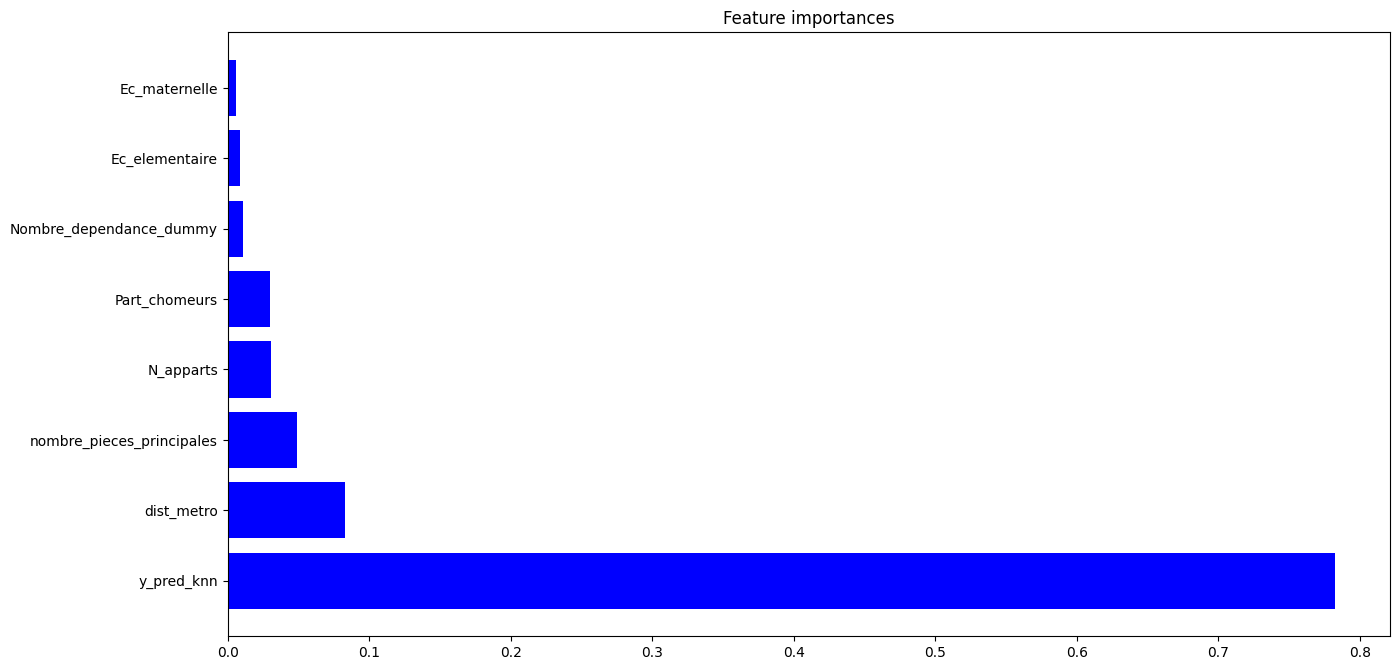

In [284]:
RF_importances = RF_model.best_estimator_.named_steps["RForest"].feature_importances_
features_importances(RF_importances, X_train_rf)

In [274]:
X_test = df_test.copy()
X_test['y_pred_knn'] = knn_pipe.predict(X_test[features_knn])

In [275]:
y_pred = RF_model.predict(X_test[features_RF + ['y_pred_knn']])
X_test["y_pred"] = y_pred
X_test['y_true'] = df_test[label_test]
X_test['mdape'] = np.abs((X_test['y_true'] - X_test["y_pred"])/X_test['y_true'])*100
X_test.head(3)

,id_mutation,date_mutation,code_type_local,code_commune,surface_terrain,surface_reelle_bati,nombre_pieces_principales,nature_culture,valeur_fonciere,latitude,longitude,nombre_lots,numero_disposition,code_departement,Nombre_unite,Nombre_dependance,Year,num_trimestre,quarter,geometry,index_right,epci_name,iris_code,iris_name,iris_name_l,Prix_m2,Month,Pris_m2_moy_iris,std,Vente_par_iris,Vente_par_iris_tri,N_logements,N_res_ppale,N_res_second,N_vacant,N_maisons,N_apparts,N_proprietaire,N_locataire,DISP_MED19,Ec_maternelle,Ec_elementaire,P19_LOG,P19_RP_SDB,P19_RP_CCCOLL,P19_RP_CCIND,P19_RP_CINDELEC,UU2020,COM,TRIRIS,GRD_QUART,TYP_IRIS,P19_POP1564,P19_POP1524,P19_POP2554,P19_POP5564,P19_ACT1564,P19_CHOM1564,P19_INACT1564,Part_dactifs,Part_chomeurs,Arrondissement,dist_metro,dist_metro_dummy,Nombre_dependance_dummy,nombre_pieces_principales_dummy,y_pred_knn,y_pred,y_true,mdape
175,2021-1057004,2021-04-09,2.0,69389,0.0,81.0,4.0,0,354400.0,45.768411,4.802712,2,1,69,1,1,2021,2,2021_Q2,POINT (4.802712 45.768411),14464,['MÃÂ©tropole de Lyon'],693890403,Le BÃÂ©al-Gorge de Lou,le bÃÂ©al-gorge de loup,4375.308642,4,4569.105699,932.843681,231,10,2093.0,1838.0,51.0,204.0,112.0,1963.0,579.0,1244.0,19790,1,1,2094.499045,1638.539607,583.962651,645.97907,595.27547,760,69389,691161,6938904,H,2428.018923,537.129556,1488.327205,402.562163,1739.71937,290.450895,688.299553,0.716518,0.119625,69389,265.545175,1,1,1,4564.161829,4326.384448,4375.308642,1.118188
176,2021-1057247,2021-04-22,2.0,69389,0.0,49.0,2.0,0,261100.0,45.768258,4.801480,1,1,69,1,1,2021,2,2021_Q2,POINT (4.80148 45.768258),14464,['MÃÂ©tropole de Lyon'],693890403,Le BÃÂ©al-Gorge de Lou,le bÃÂ©al-gorge de loup,5328.571429,4,4569.105699,932.843681,231,10,2093.0,1838.0,51.0,204.0,112.0,1963.0,579.0,1244.0,19790,1,1,2094.499045,1638.539607,583.962651,645.97907,595.27547,760,69389,691161,6938904,H,2428.018923,537.129556,1488.327205,402.562163,1739.71937,290.450895,688.299553,0.716518,0.119625,69389,329.906758,1,1,0,4321.448732,4964.916310,5328.571429,6.824627
177,2021-1057285,2021-04-23,2.0,69389,0.0,49.0,2.0,0,217650.0,45.770265,4.801465,1,1,69,1,0,2021,2,2021_Q2,POINT (4.801465 45.770265),14464,['MÃÂ©tropole de Lyon'],693890403,Le BÃÂ©al-Gorge de Lou,le bÃÂ©al-gorge de loup,4441.836735,4,4569.105699,932.843681,231,10,2093.0,1838.0,51.0,204.0,112.0,1963.0,579.0,1244.0,19790,1,1,2094.499045,1638.539607,583.962651,645.97907,595.27547,760,69389,691161,6938904,H,2428.018923,537.129556,1488.327205,402.562163,1739.71937,290.450895,688.299553,0.716518,0.119625,69389,486.577541,1,0,0,4896.591407,4145.602634,4441.836735,6.669180


In [276]:
def tab_latex(tab, variable) : 
    if variable == 'Arrondissement' : 
        tab['Arrondissement'] = tab['Arrondissement'].astype(int).astype(str).str[4]
    tab = round(tab, 3)
    tab = tab.set_index(variable)
    tab = tab.T
    return(tab.to_latex())

In [277]:
X_test.groupby('Arrondissement').agg({'mdape' : 'median'}).reset_index().set_index('Arrondissement').T

Arrondissement,69381,69382,69383,69384,69385,69386,69387,69388,69389
mdape,9.842964,10.968654,7.238813,9.728509,8.800586,9.104895,8.122175,8.618564,9.071274


In [278]:
X_test.groupby('quarter').agg({'mdape' : 'median'}).reset_index().set_index('quarter').T

quarter,2021_Q2,2021_Q3,2021_Q4,2022_Q1,2022_Q2
mdape,8.507777,8.388363,9.028803,8.985574,8.848869


In [270]:
fig = px.scatter(X_test, x = 'surface_reelle_bati', y = 'mdape')
fig.update_layout(yaxis_range=[-0.5, 150])
fig.show()

In [271]:
fig = px.scatter(X_test, x = 'valeur_fonciere', y = 'mdape')
fig.update_layout(yaxis_range=[-0.5, 150])
fig.show()

In [264]:
tab = X_test.groupby('Arrondissement').agg({'mdape' : 'median'}).reset_index()
tab_latex(tab, 'Arrondissement')

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\nArrondissement &      1 &       2 &      3 &      4 &      5 &      6 &      7 &      8 &      9 \\\\\n\\midrule\nmdape &  9.843 &  10.969 &  7.239 &  9.729 &  8.801 &  9.105 &  8.122 &  8.619 &  9.071 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [279]:
tab = X_test.groupby('quarter').agg({'mdape' : 'median'}).reset_index()
tab_latex(tab, 'quarter')

'\\begin{tabular}{lrrrrr}\n\\toprule\nquarter &  2021\\_Q2 &  2021\\_Q3 &  2021\\_Q4 &  2022\\_Q1 &  2022\\_Q2 \\\\\n\\midrule\nmdape &    8.508 &    8.388 &    9.029 &    8.986 &    8.849 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Gradient Boost

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('GBoost', GradientBoostingRegressor())])
parameters = {'GBoost__n_estimators': [50, 100, 150]} # defining parameter space
gboost_pipe = GridSearchCV(pipe, parameters, cv=5)
gboost_pipe.fit(X_train_rf, y_train)

compute_scores(gboost_pipe, X_test_rf, y_test)

In [ ]:
gboost_pipe.best_params_

In [ ]:
#dummies_pr_var_continues(df, 'dist_metro', 0.01)

**Features importance**

In [ ]:
model_rf = RandomForestRegressor(max_depth=10)
model_rf.fit(X_train_rf, y_train)

#Prediciton 
y_pred_rf = model_rf.predict(X_test_rf)

importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train_rf.columns
# plot
nb_features = X_train_rf.shape[1]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.barh(
    range(nb_features),
    importances[indices],
    color='b')
plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
plt.show()

XG BOOST

In [ ]:
df_train.columns

In [ ]:
model_gb = GradientBoostingRegressor(n_estimators = 100)
model_gb.fit(X_train_rf, y_train)

#Prediciton 
y_pred_rf = model_gb.predict(X_test_rf)

importances = model_gb.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train_rf.columns
# plot
nb_features = X_train_rf.shape[1]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.barh(
    range(nb_features),
    importances[indices],
    color='b')
plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
plt.show()